In [133]:
%env MNE_USE_NUMBA false

env: MNE_USE_NUMBA=false


In [134]:
import mne

In [135]:
import pandas as pd

In [136]:
import numpy as np

In [137]:
import matplotlib.pyplot as plt

In [138]:
import json

In [139]:
devices = json.load(open('../devices.json'))

In [140]:
client_id = 'mock-session'

In [141]:
sampling_freq = devices["OpenBCI8"]['sampling_rate']
ch_names = devices["OpenBCI8"]['channels']

In [142]:
signal_df = pd.read_csv(f"../{client_id}.csv")

<AxesSubplot:>

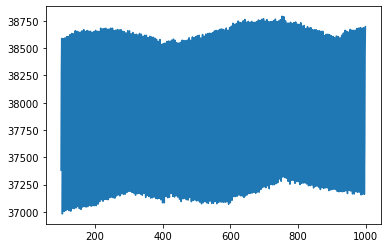

In [143]:
signal_df['Fp1'].iloc[100:1000].plot()

In [144]:
# signal_df = pd.read_csv("""/home/noomkcalb/Documents/projects/game-emotions/client-sdk/brainflow_data.csv""", header=None, sep='\t')

# signal_df = signal_df[list(range(1, 9)) + [30]].copy()

# signal_df.columns = ['Fp1', 'Fp2', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'time']

# for c in signal_df.columns:
#     signal_df[c] = signal_df[c].str.replace(",", ".").astype(float)

In [145]:
signal_df = signal_df.set_index('time')

In [146]:
ch_types = ['eeg'] * len(ch_names)

# Restore raw signal

In [147]:
def get_raw_signal(signal_df, ch_names, ch_types, sampling_freq):
    signal_df.columns = ch_names

    # signal_df["time"] = pd.to_datetime(signal_df["time"]).dt.strftime("%Y-%m-%d %H:%M:%S")
#     signal_df["time"] = pd.to_datetime(signal_df["timestamp"], unit='ms')
    
    signal_info = mne.create_info(
        ch_names, 
        ch_types=ch_types, 
        sfreq=sampling_freq
    )
    signal_info.set_montage('standard_1020')
#     signal_info["start_time"] = signal_df["time"].min()
    
    data = signal_df[ch_names].values.T
    raw = mne.io.RawArray(data, signal_info)

#     # Filter line noise
    raw.notch_filter(50, notch_widths=3)

#     # Filter nessesary frequencies
    raw.filter(1, 50)
    
    return raw

In [148]:
raw = get_raw_signal(
    signal_df,
    ch_names=ch_names,
    ch_types=ch_types,
    sampling_freq=sampling_freq
)

Creating RawArray with float64 data, n_channels=8, n_times=35712
    Range : 0 ... 35711 =      0.000 ...   142.844 secs
Ready.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 48.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 47.75 Hz)
- Upper passband edge: 52.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 52.25 Hz)
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lowe

In [149]:
%matplotlib inline

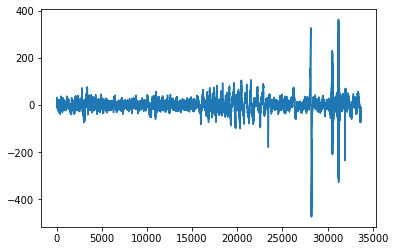

In [150]:
plt.plot(raw.get_data()[0, 1000:-1000])

# Get localized bands

In [151]:
def get_sampling_freq_deg_two(n):
    n = int(n)
    d = 0
    while n > 0:
        n = n >> 1
        d += 1
    return 2 ** d

In [152]:
get_sampling_freq_deg_two(250.0)

256

In [153]:
def get_bands(raw, locations_dict, bands_dict, window_size=16):
    sampling_freq = get_sampling_freq_deg_two(raw.info['sfreq'])
    
    location_band_channels = {}
    for location_name, channels in locations_dict.items():
        band_channels = {}
        
        for name, frequencies in bands_dict.items():
            channel_raw = raw.copy().pick(channels).get_data(channels)
            channel_fft = np.abs(
                mne.time_frequency.stft(channel_raw, sampling_freq, window_size)
            )
            # Average all frequencies, then among channels
            band_channel = channel_fft[:, frequencies, :].mean(axis=1).mean(axis=0)
            band_channel = band_channel[window_size:-window_size]
            band_channels[name] = band_channel
        location_band_channels[location_name] = band_channels
    
    return location_band_channels

In [154]:
location_band_channels = get_bands(
    raw, 
    {
        'frontal_left': ['Fp1'],
        'frontal_temporal': ['Fp1']
    }, 
    {
        'alpha': np.arange(8, 15), 
        'beta': np.arange(15, 25),
        'theta': np.arange(4, 8)
    }
)

Number of frequencies: 129
Number of time steps: 2232
Number of frequencies: 129
Number of time steps: 2232
Number of frequencies: 129
Number of time steps: 2232
Number of frequencies: 129
Number of time steps: 2232
Number of frequencies: 129
Number of time steps: 2232
Number of frequencies: 129
Number of time steps: 2232


# Get indicators

Нужно исправить время

In [155]:
def get_flow():
    global location_band_channels
    frontal_left_alpha = location_band_channels['frontal_left']['alpha']
    frontal_left_beta = location_band_channels['frontal_left']['beta']
    
    return frontal_left_beta / frontal_left_alpha - 1

In [156]:
def get_anxiety():
    global location_band_channels
    frontal_left_alpha = location_band_channels['frontal_temporal']['theta']
    frontal_left_beta = location_band_channels['frontal_temporal']['beta']
    
    return frontal_left_beta / frontal_left_alpha - 1

In [157]:
indicators = {
    'flow': get_flow,
    'anxiety': get_anxiety
}

In [158]:
indicators_df = pd.DataFrame()

In [159]:
for indicator, func in indicators.items():
    indicators_df[indicator] = func()

In [160]:
n_samples = indicators_df.shape[0]
signal_time = raw.times.max()

In [161]:
time = np.linspace(0, signal_time, n_samples)

In [162]:
time.max()

142.844

In [163]:
indicators_df.index = time
indicators_df.index.name = 'time'

In [164]:
# indicators_df['anxiety'] = indicators_df['flow']
indicators_df['boredom'] = 1 / indicators_df['flow']

In [165]:
for c in indicators_df.columns:
    min_value = indicators_df[c].min()
    max_value = indicators_df[c].max() 
    indicators_df[c] = (indicators_df[c] - min_value) / (max_value - min_value)

In [166]:
indicators_df.to_csv(f'../{client_id}-indicators.csv')

<AxesSubplot:xlabel='time'>

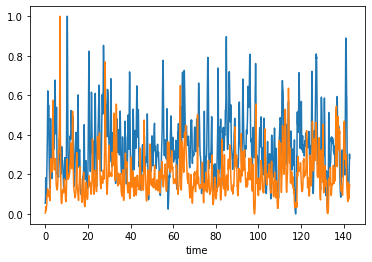

In [167]:
indicators_df['flow'].plot()
indicators_df['anxiety'].plot()